In [1]:
import os
import json
import pandas as pd

In [2]:
base_dir = r"G:\LLM-fine-tuning-LinkedIn-Post\legalbench"

json_files = {
    "Base 3B": os.path.join(base_dir, "base_model_3B.json"),
    "Base 7B": os.path.join(base_dir, "base_model_7B.json"),
    "Standard LoRA": os.path.join(base_dir, "standard_lora_legalbench.json"),
    "QLoRA": os.path.join(base_dir, "qlora_legalbench.json")
}

In [3]:
data_dict = {}
for name, path in json_files.items():
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
        data_dict[name] = data.get("task_scores", {})

In [4]:
# Use the 15 reference tasks explicitly from your QLoRA JSON
reference_tasks = set([
    "contract_nli_confidentiality_of_agreement",
    "contract_nli_permissible_copy",
    "contract_nli_return_of_confidential_information",
    "contract_qa",
    "cuad_third_party_beneficiary",
    "hearsay",
    "jcrew_blocker",
    "legal_reasoning_causality",
    "maud_pandemic_or_other_public_health_event__subject_to_disproportionate_impact_modifier",
    "maud_pandemic_or_other_public_health_event_specific_reference_to_pandemic-related_governmental_responses_or_measures",
    "personal_jurisdiction",
    "proa",
    "telemarketing_sales_rule",
    "ucc_v_common_law",
    "consumer_contracts_qa"
])

# Combine into DataFrame but only for reference tasks
rows = []
for model_name, scores in data_dict.items():
    for task in reference_tasks:
        rows.append({
            "task": task,
            "model": model_name,
            "score": scores.get(task, None)  # None if missing
        })

combined_df = pd.DataFrame(rows).sort_values(["task", "model"]).reset_index(drop=True)
combined_df.head()


,task,model,score
0,consumer_contracts_qa,Base 3B,0.752577
1,consumer_contracts_qa,Base 7B,0.863674
2,consumer_contracts_qa,QLoRA,0.559504
3,consumer_contracts_qa,Standard LoRA,0.664983
4,contract_nli_confidentiality_of_agreement,Base 3B,0.000000


In [5]:
# Round the score column to 4 decimal places
combined_df["score"] = combined_df["score"].round(4)

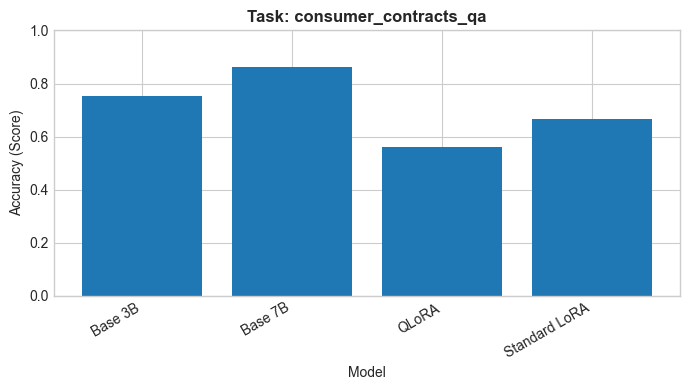

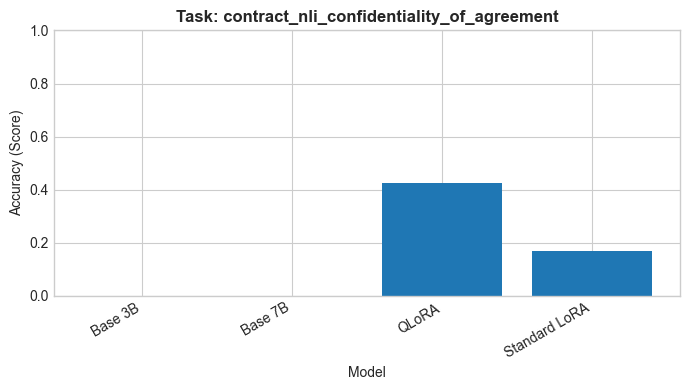

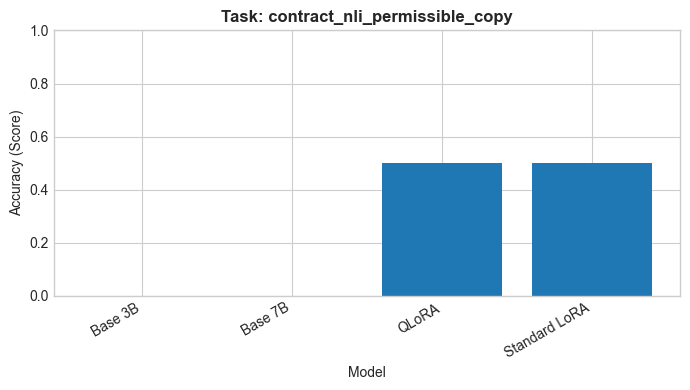

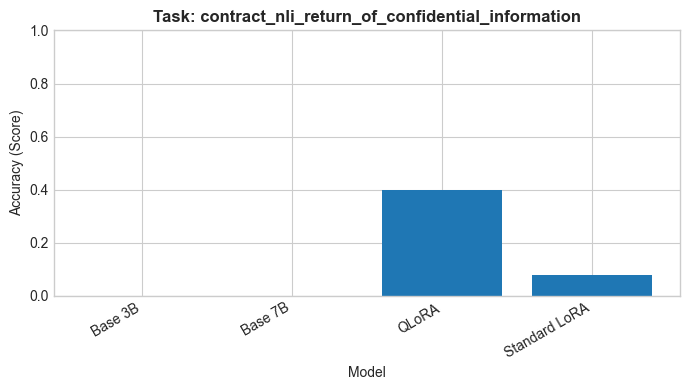

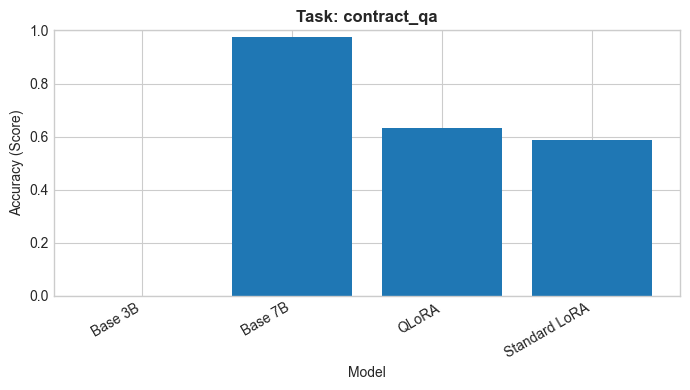

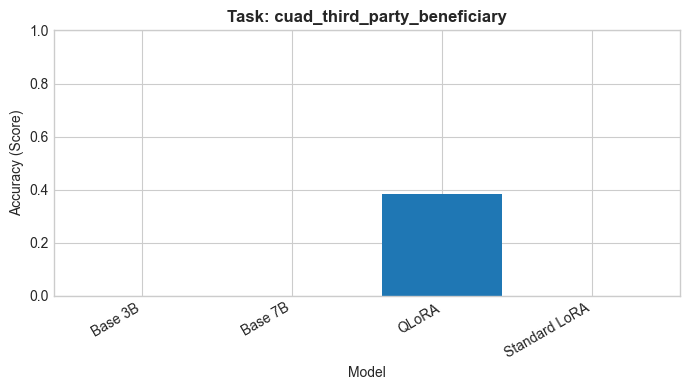

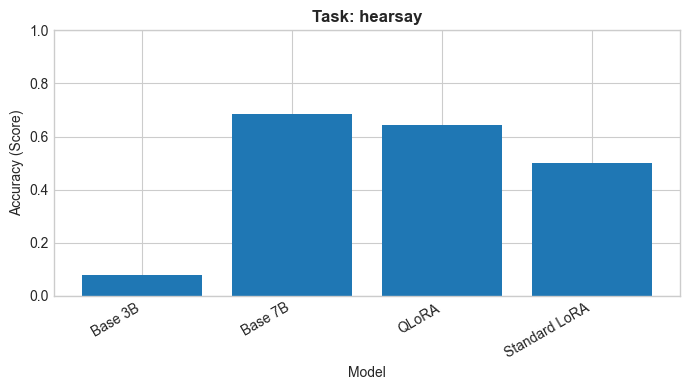

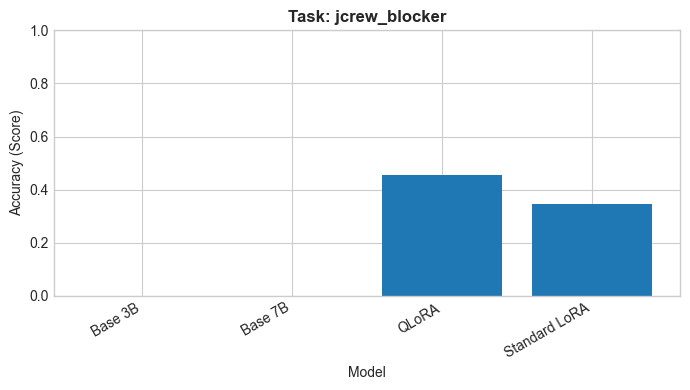

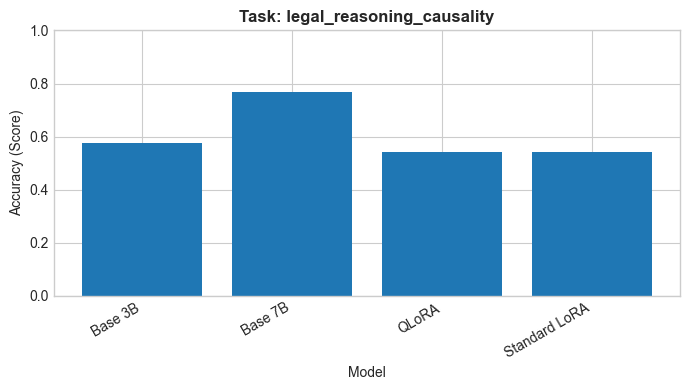

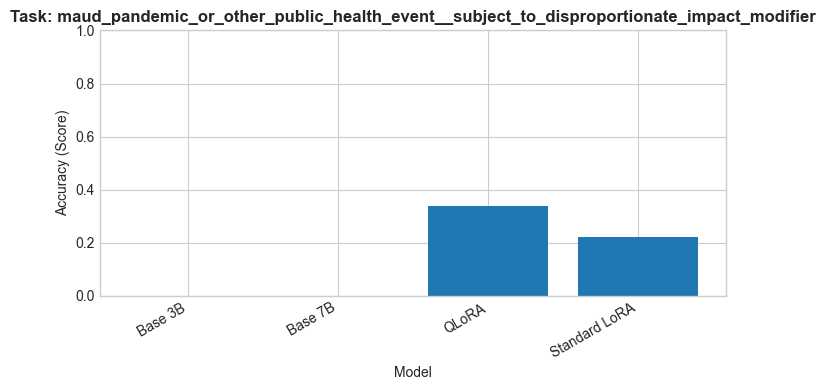

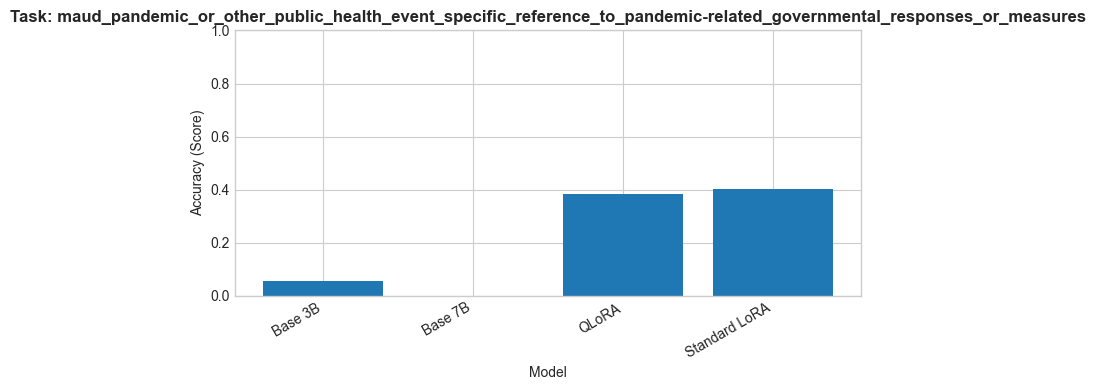

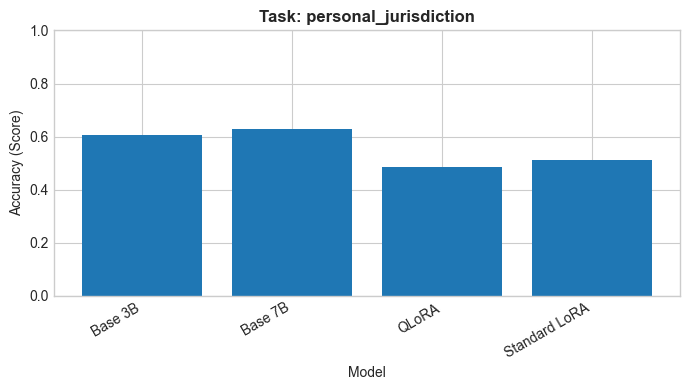

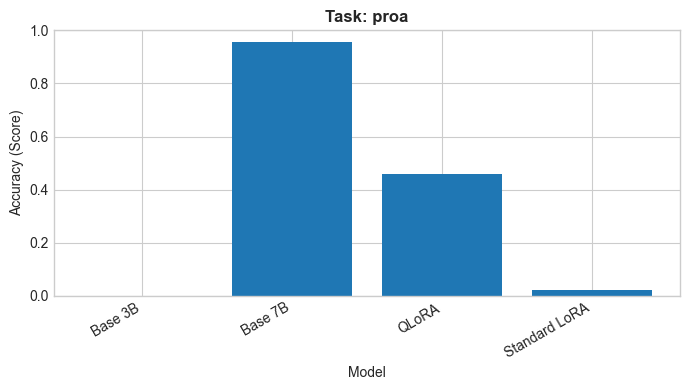

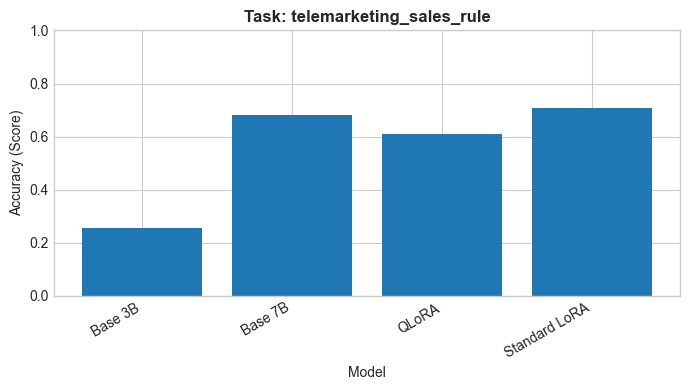

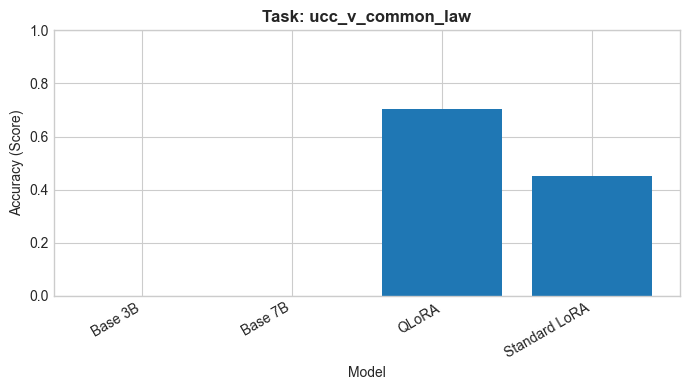

In [6]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

tasks = combined_df["task"].unique()

for task in tasks:
    task_df = combined_df[combined_df["task"] == task]
    
    plt.figure(figsize=(7, 4))
    plt.bar(task_df["model"], task_df["score"])
    plt.title(f"Task: {task}", fontsize=12, weight='bold')
    plt.xlabel("Model")
    plt.ylabel("Accuracy (Score)")
    plt.ylim(0, 1)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()


In [ ]:
import plotly.graph_objects as go
import pandas as pd

pivot_df = combined_df.pivot(index="task", columns="model", values="score")

pivot_df = pivot_df.sort_values(by="Base 7B", ascending=True)

label_map = {
    "maud_pandemic_or_other_public_health_event__subject_to_disproportionate_impact_modifier": "maud_modifier",
    "maud_pandemic_or_other_public_health_event_specific_reference_to_pandemic-related_governmental_responses_or_measures": "maud_measures",
    "contract_nli_return_of_confidential_information": "contract_nli_information",
    "contract_nli_confidentiality_of_agreement": "contract_nli_agreement"
}
pivot_df["display_label"] = pivot_df.index.map(lambda t: label_map.get(t, t))

model_colors = {
    "Base 3B": "#264653",
    "Base 7B": "#2a9d8f",
    "Standard LoRA": "#f4a261",
    "QLoRA": "#e76f51"
}

fig = go.Figure()

for model in pivot_df.columns.drop("display_label"):
    fig.add_trace(go.Bar(
        x=pivot_df["display_label"],
        y=pivot_df[model],
        name=model,
        marker_color=model_colors.get(model, "#333333")
    ))

fig.update_layout(
    barmode='group',
    xaxis=dict(
        title=dict(
            text='Tasks',
            font=dict(family="cursive", size=14, color='black')
        ),
        showline=True,
        linewidth=2,
        linecolor='black',
        tickfont=dict(family="cursive")
    ),
    yaxis=dict(
        title=dict(
            text='Accuracy',
            font=dict(family="cursive", size=14, color='black')
        ),
        showline=True,
        linewidth=2,
        linecolor='black',
        range=[0, 1],
        tickfont=dict(family="cursive")
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend=dict(
        title='       Models',
        x=0.02,
        y=0.98,
        xanchor='left',
        yanchor='top',
        borderwidth=0,
        font=dict(family="cursive")
    ),
    font=dict(family="cursive", size=12, color='black'),
    title=dict(
        text="Results",
        x=0.5,
        xanchor='center',
        font=dict(family="cursive", size=18, color='black')
    ),
    width=1000,
    height=550
)

fig.show()


In [ ]:
ranked_df = combined_df.copy()
ranked_df["rank"] = ranked_df.groupby("task")["score"].rank(ascending=False, method="min")

ranked_df = ranked_df.sort_values(["task", "rank"]).reset_index(drop=True)

for task in ranked_df["task"].unique():
    print(f"\n🔹 Task: {task}")
    task_rows = ranked_df[ranked_df["task"] == task][["model", "score", "rank"]]
    for _, row in task_rows.iterrows():
        print(f"  {int(row['rank'])}. {row['model']} — {row['score']:.4f}")

ranked_df



🔹 Task: consumer_contracts_qa
  1. Base 7B — 0.8637
  2. Base 3B — 0.7526
  3. Standard LoRA — 0.6650
  4. QLoRA — 0.5595

🔹 Task: contract_nli_confidentiality_of_agreement
  1. QLoRA — 0.4268
  2. Standard LoRA — 0.1707
  3. Base 3B — 0.0000
  3. Base 7B — 0.0000

🔹 Task: contract_nli_permissible_copy
  1. QLoRA — 0.5000
  1. Standard LoRA — 0.5000
  3. Base 3B — 0.0000
  3. Base 7B — 0.0000

🔹 Task: contract_nli_return_of_confidential_information
  1. QLoRA — 0.4007
  2. Standard LoRA — 0.0781
  3. Base 3B — 0.0000
  3. Base 7B — 0.0000

🔹 Task: contract_qa
  1. Base 7B — 0.9744
  2. QLoRA — 0.6329
  3. Standard LoRA — 0.5854
  4. Base 3B — 0.0000

🔹 Task: cuad_third_party_beneficiary
  1. QLoRA — 0.3824
  2. Base 3B — 0.0000
  2. Base 7B — 0.0000
  2. Standard LoRA — 0.0000

🔹 Task: hearsay
  1. Base 7B — 0.6866
  2. QLoRA — 0.6424
  3. Standard LoRA — 0.5000
  4. Base 3B — 0.0782

🔹 Task: jcrew_blocker
  1. QLoRA — 0.4556
  2. Standard LoRA — 0.3444
  3. Base 3B — 0.0000
  3. Base

,task,model,score,rank
0,consumer_contracts_qa,Base 7B,0.8637,1.0
1,consumer_contracts_qa,Base 3B,0.7526,2.0
2,consumer_contracts_qa,Standard LoRA,0.6650,3.0
3,consumer_contracts_qa,QLoRA,0.5595,4.0
4,contract_nli_confidentiality_of_agreement,QLoRA,0.4268,1.0
5,contract_nli_confidentiality_of_agreement,Standard LoRA,0.1707,2.0
6,contract_nli_confidentiality_of_agreement,Base 3B,0.0000,3.0
7,contract_nli_confidentiality_of_agreement,Base 7B,0.0000,3.0
8,contract_nli_permissible_copy,QLoRA,0.5000,1.0
9,contract_nli_permissible_copy,Standard LoRA,0.5000,1.0
